### Считывание и процессинг

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

# датасет содержит 1100001 записей
df = pd.read_csv('dataset.csv', sep=';')

In [2]:
# удалить пустые / na строки
df.dropna(inplace=True)
# удалить дубли
df.drop_duplicates(inplace=True)
# строки в которых нет цифр превратить в пустые
df.fillna('', inplace=True)
# удалить записи в промежутке от 1 до 3 часов ночи
df.date_reg = pd.to_datetime(df.date_reg)
df = df[(df.date_reg.dt.hour < 1) | (df.date_reg.dt.hour >= 3)]

### Расчет метрик

In [3]:
# Агрегация по времени, для каждого часа рассчитать:
# - кол-во уникальных string
df['hour'] = df.date_reg.dt.hour
df_count_names = df.groupby(df.hour).name.agg('nunique').reset_index() \
    .rename(columns={'date_reg': 'hour', 'name': 'nunique_names'})
df_count_names.head()

,hour,nunique_names
0,0,28742
1,3,28709
2,4,28568
3,5,28596
4,6,28691


In [4]:
# - среднее и медиану для numeric
df_mean_median = df.groupby(df.hour).value.agg(['mean', 'median']).reset_index() \
    .rename(columns={'date_reg': 'hour'})
df_mean_median.head()

,hour,mean,median
0,0,500.747232,500.315282
1,3,499.723290,498.919094
2,4,500.681765,500.129634
3,5,499.909252,500.492001
4,6,501.081856,500.601137


In [ ]:
'''SQL запрос: кол-во уникальных string для каждого часа

SELECT EXTRACT(HOUR FROM date_reg) AS hour, COUNT(DISTINCT name) AS nunique_names
FROM df
GROUP BY EXTRACT(HOUR FROM date_reg)
ORDER BY 1;


SQL запрос: среднее и медиана для numeric

SELECT EXTRACT(HOUR FROM date_reg) AS hour, AVG(value) AS mean,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY value) AS median
FROM df
GROUP BY EXTRACT(HOUR FROM date_reg)
ORDER BY 1;'''

### Мерж с метриками

In [5]:
# К каждой строке в исходном датасете примержить метрики ближайшего часа рассчитанные в предыдущем шаге
df = pd.merge(df, df_count_names, on='hour', how='left')
df = pd.merge(df, df_mean_median, on='hour', how='left')
df.drop(columns='hour', inplace=True)
df.head()

,value,date_reg,name,nunique_names,mean,median
0,555.741121,2022-12-03 10:08:00,Lori Meyer,28817,500.207553,500.394085
1,609.620670,2021-05-12 14:33:41,Christine Fowler,28754,499.391720,499.609100
2,391.421053,2022-03-17 18:53:34,Jason Brown,28534,500.278164,499.956966
3,466.679145,2021-10-19 08:39:25,Paul Vargas,28910,500.035717,500.069308
4,598.853048,2020-09-03 07:28:54,Amy Smith,28629,500.522291,500.917737


### Аналитические метрики

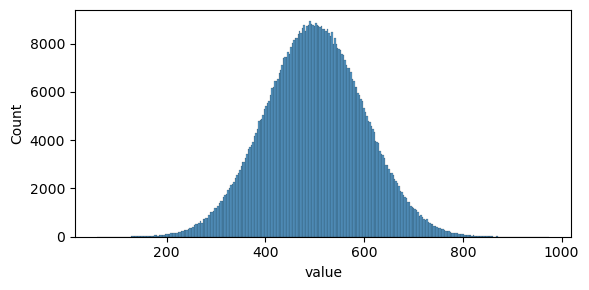

In [6]:
# Для колонки numeric по полному датасету построить:
# - Гистограмму
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
sns.histplot(df.value)
plt.tight_layout()

In [7]:
# - 95% доверительный интервал, с комментарием как выбирали методику расчета
# Поскольку данные распределены нормально и количество значений больше 30,
# то для нахождения 95% доверительного интервала будем использовать z-распределение.
import scipy.stats as st

st.norm.interval(confidence=0.95, loc=np.mean(df.value), scale=st.sem(df.value))

(499.88766619137294, 500.3410529726464)

In [8]:
#... или же вычислив среднее, стандартное отклонение и найдя в таблице
# z-значение для 95% ДИ (1.96), рассчитать с помощью формулы.
print(np.mean(df.value) - 1.96 * st.sem(df.value), np.mean(df.value) + 1.96 * st.sem(df.value))

499.88766202575215 500.3410571382672


### Визуализация

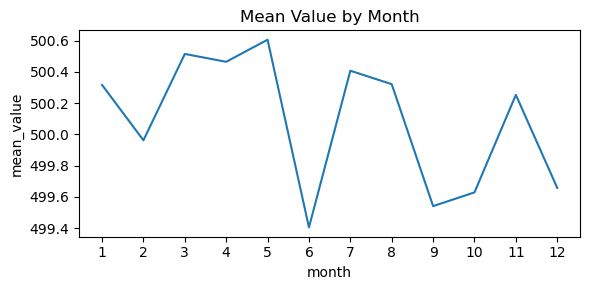

In [9]:
# Отрисовать график среднего значения numeric колонки (y) по месяцам (x)
df_mean_by_month = df.groupby(df.date_reg.dt.month).value.agg('mean').reset_index() \
    .rename(columns={'date_reg': 'month', 'value': 'mean_value'})
df_mean_by_month.head()

plt.figure(figsize=(6, 3))
plt.title('Mean Value by Month')
plt.xticks(df_mean_by_month.month)
sns.lineplot(data=df_mean_by_month, x='month', y='mean_value')
plt.tight_layout()

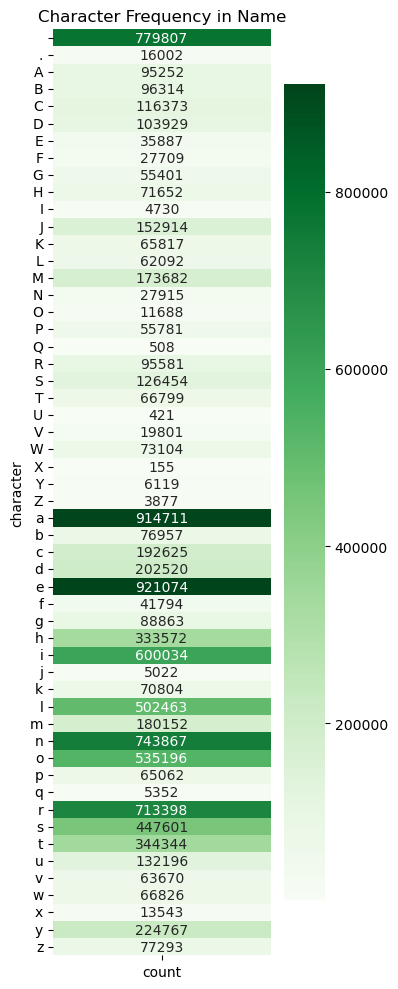

In [10]:
# Heatmap по частотности символов в колонке string
from collections import Counter

all_strings = ''.join(df.name)
char_counts = Counter(all_strings)

df_char = pd.DataFrame(list(char_counts.items()), columns=['character', 'count']).sort_values('character')
df_char.set_index('character', inplace=True)

plt.figure(figsize=(4, 10))
sns.heatmap(df_char, annot=True, fmt='d', cmap='Greens', cbar=True)
plt.title('Character Frequency in Name')
plt.yticks(rotation=0)
plt.tight_layout()

### Доп. задание

In [11]:
# Случайно поделить датасет на 3 части - в одной 25% записей, во второй 25% и 50% в третьей
from sklearn.model_selection import train_test_split

df_half1, df_half2 = train_test_split(df, train_size=0.5, random_state=42)
df_quarter1, df_quarter2 = train_test_split(df_half2, train_size=0.5, random_state=42)

In [12]:
# Проверить на статистическую значимость различий для среднего по колонке numeric
from scipy.stats import f_oneway

f_oneway(df_quarter1.value, df_quarter2.value, df_half1.value)

F_onewayResult(statistic=1.199931823043456, pvalue=0.3012153282240274)

In [135]:
'''Оценить силу эффекта
F-статистика результата ANOVA не велика, это означает, что 
дисперсия между группами не сильно отличается от дисперсии внутри групп.
p-value говорит о том, что нет оснований утверждать, что имеются
статистически значимые отличия между группами. Следовательно, нудевая
гипотеза о равенстве средних в группах не может быть отклонена.'''

In [13]:
# Проделать шаги 2 и 3 используя баесовский подход
from scipy.stats import bayes_mvs

mean_confidence_quarter1, var_confidence_quarter1, std_confidence_quarter1 = bayes_mvs(df_quarter1.value, alpha=0.95)
mean_confidence_quarter2, var_confidence_quarter2, std_confidence_quarter2 = bayes_mvs(df_quarter2.value, alpha=0.95)
mean_confidence_half1, var_confidence_half1, std_confidence_half1 = bayes_mvs(df_half1.value, alpha=0.95)
print(mean_confidence_quarter1.minmax, mean_confidence_quarter2.minmax, mean_confidence_half1.minmax, sep='\n')
# Доверительные интервалы пересекаются, следовательно значимых отличий между датасетами нет.

(499.91438440392136, 500.82020339831405)
(499.7462177808243, 500.6529656363517)
(499.6245115685205, 500.2660406930632)


In [ ]:
'''Кратко описать как выбирали методы расчета
Был выбран ANOVA, так как имеем несколько выборок (3),
выборки независимы между собой, данные количественные 
и распределены нормально.'''